In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('LABELED_ANOMALIES.csv')

# Initial Exploratory Data Analysis (EDA)
print("Initial DataFrame Info:")
print(df.info())
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

# Handling missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Since there are no missing values, we proceed to handle outliers
# For simplicity, let's assume we are only normalizing the 'num_values' column

# Normalizing features
scaler = StandardScaler()
df['num_values_normalized'] = scaler.fit_transform(df[['num_values']])

print("\nFirst 5 rows after normalization:")
print(df.head())

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   chan_id            82 non-null     object
 1   spacecraft         82 non-null     object
 2   anomaly_sequences  82 non-null     object
 3   class              82 non-null     object
 4   num_values         82 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.3+ KB
None

First 5 rows of the DataFrame:
  chan_id spacecraft                           anomaly_sequences  \
0     P-1       SMAP  [[2149, 2349], [4536, 4844], [3539, 3779]]   
1     S-1       SMAP                              [[5300, 5747]]   
2     E-1       SMAP                [[5000, 5030], [5610, 6086]]   
3     E-2       SMAP                              [[5598, 6995]]   
4     E-3       SMAP                              [[5094, 8306]]   

                                  class  num_valu


Anomalies detected using Z-score:
Empty DataFrame
Columns: [chan_id, spacecraft, anomaly_sequences, class, num_values, num_values_normalized, z_score, anomaly_z_score, anomaly_iso_forest, anomaly_oc_svm]
Index: []

Anomalies detected using Isolation Forest:
   chan_id spacecraft                           anomaly_sequences  \
47     A-5       SMAP                              [[2750, 2800]]   
48     A-6       SMAP                              [[1890, 1930]]   
59    P-10        MSL                              [[4590, 4720]]   
62     F-7        MSL  [[1250, 1450], [2670, 2790], [3325, 3425]]   
72     F-5        MSL                              [[3550, 3700]]   
74     T-9        MSL                    [[780, 810], [890, 970]]   
75    P-14        MSL                              [[4575, 4755]]   
76     T-8        MSL                  [[870, 930], [1330, 1370]]   
77    P-11        MSL                [[1778, 1898], [1238, 1344]]   

                                   class  num_valu

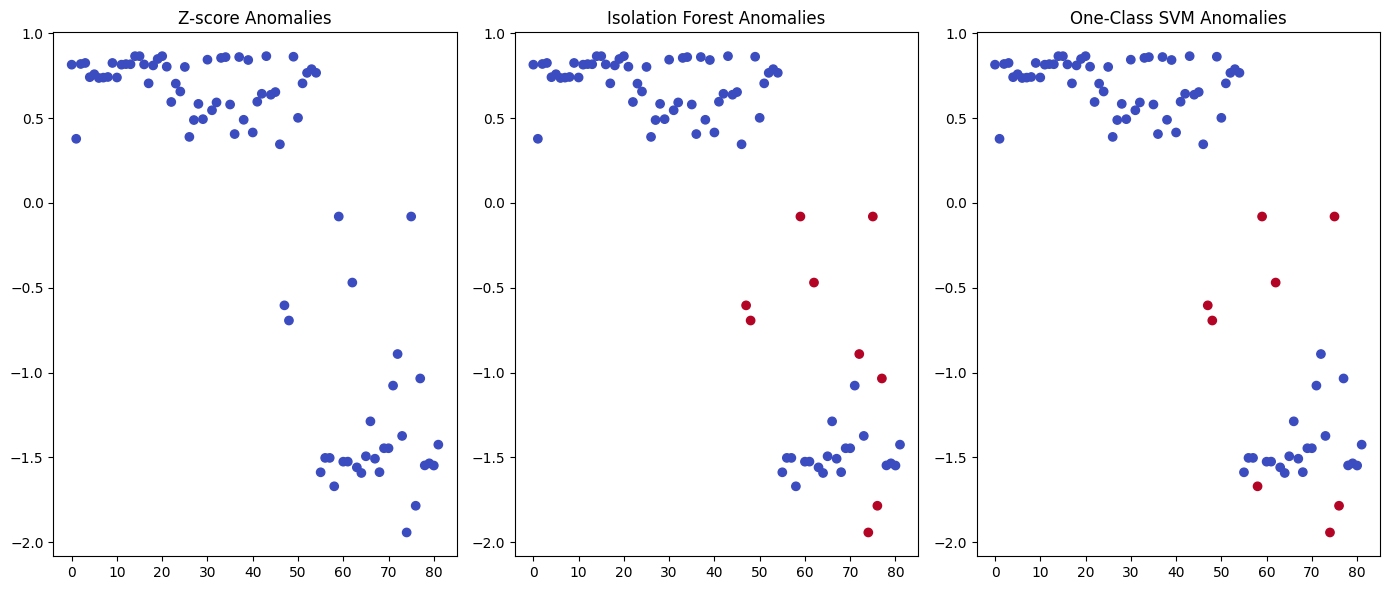

In [2]:
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt

# Z-score for univariate anomaly detection
df['z_score'] = np.abs(stats.zscore(df['num_values_normalized']))
df['anomaly_z_score'] = df['z_score'] > 3

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1)
df['anomaly_iso_forest'] = iso_forest.fit_predict(df[['num_values_normalized']])
df['anomaly_iso_forest'] = df['anomaly_iso_forest'] == -1

# One-Class SVM
oc_svm = OneClassSVM(nu=0.1)
df['anomaly_oc_svm'] = oc_svm.fit_predict(df[['num_values_normalized']])
df['anomaly_oc_svm'] = df['anomaly_oc_svm'] == -1

# Display the results
print("\nAnomalies detected using Z-score:")
print(df[df['anomaly_z_score']])

print("\nAnomalies detected using Isolation Forest:")
print(df[df['anomaly_iso_forest']])

print("\nAnomalies detected using One-Class SVM:")
print(df[df['anomaly_oc_svm']])

# Plotting the anomalies
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.scatter(df.index, df['num_values_normalized'], c=df['anomaly_z_score'], cmap='coolwarm')
plt.title('Z-score Anomalies')

plt.subplot(1, 3, 2)
plt.scatter(df.index, df['num_values_normalized'], c=df['anomaly_iso_forest'], cmap='coolwarm')
plt.title('Isolation Forest Anomalies')

plt.subplot(1, 3, 3)
plt.scatter(df.index, df['num_values_normalized'], c=df['anomaly_oc_svm'], cmap='coolwarm')
plt.title('One-Class SVM Anomalies')

plt.tight_layout()
plt.show()

Isolation Forest - Precision: 1.0, Recall: 1.0, F1-score: 1.0
One-Class SVM - Precision: 1.0, Recall: 1.0, F1-score: 1.0


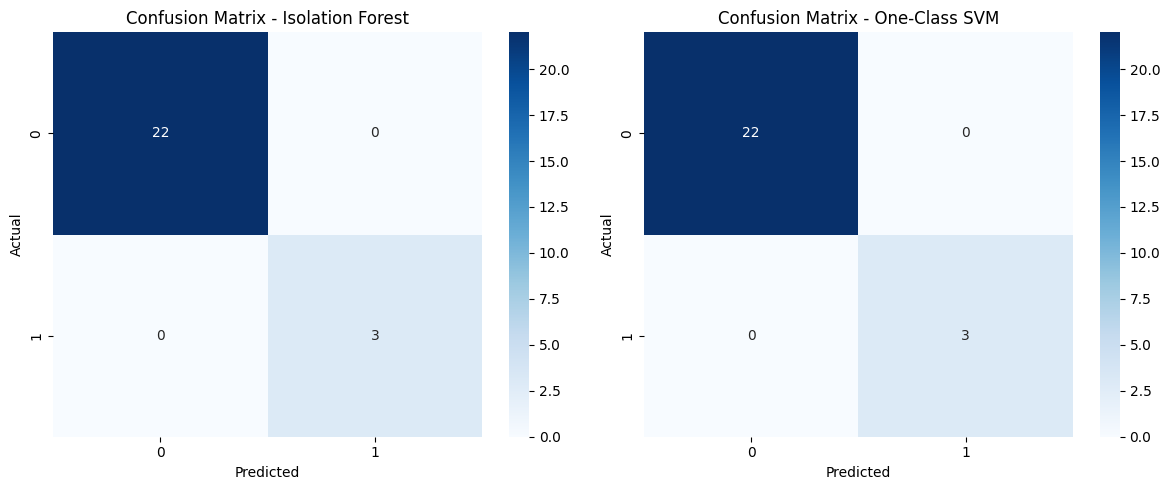

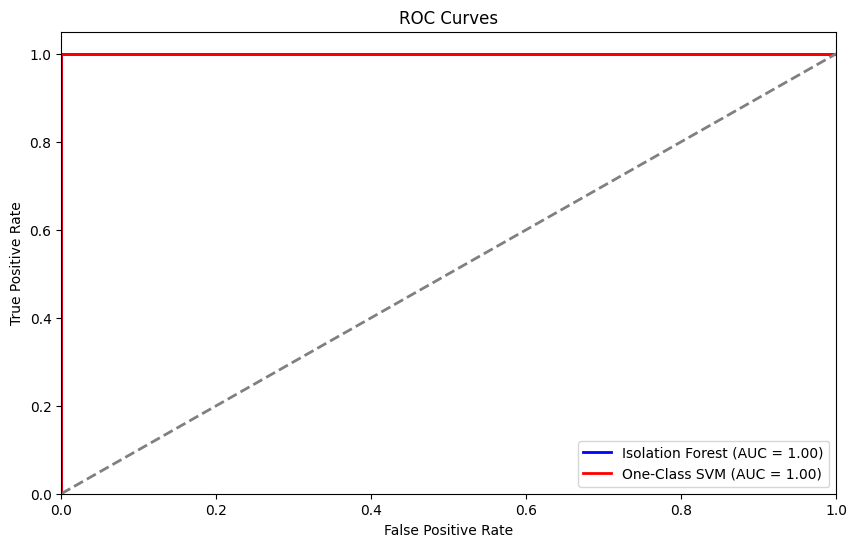

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['num_values_normalized']], df['anomaly_iso_forest'], test_size=0.3, random_state=42)

# Train the models on the training set
iso_forest.fit(X_train)
oc_svm.fit(X_train)

# Predict on the testing set
y_pred_iso_forest = iso_forest.predict(X_test) == -1
y_pred_oc_svm = oc_svm.predict(X_test) == -1

# Evaluate the performance of the models
precision_iso_forest = precision_score(y_test, y_pred_iso_forest)
recall_iso_forest = recall_score(y_test, y_pred_iso_forest)
f1_iso_forest = f1_score(y_test, y_pred_iso_forest)

precision_oc_svm = precision_score(y_test, y_pred_oc_svm)
recall_oc_svm = recall_score(y_test, y_pred_oc_svm)
f1_oc_svm = f1_score(y_test, y_pred_oc_svm)

print(f"Isolation Forest - Precision: {precision_iso_forest}, Recall: {recall_iso_forest}, F1-score: {f1_iso_forest}")
print(f"One-Class SVM - Precision: {precision_oc_svm}, Recall: {recall_oc_svm}, F1-score: {f1_oc_svm}")

# Confusion matrices
conf_matrix_iso_forest = confusion_matrix(y_test, y_pred_iso_forest)
conf_matrix_oc_svm = confusion_matrix(y_test, y_pred_oc_svm)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_iso_forest, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_oc_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - One-Class SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC curves
fpr_iso_forest, tpr_iso_forest, _ = roc_curve(y_test, y_pred_iso_forest)
roc_auc_iso_forest = auc(fpr_iso_forest, tpr_iso_forest)

fpr_oc_svm, tpr_oc_svm, _ = roc_curve(y_test, y_pred_oc_svm)
roc_auc_oc_svm = auc(fpr_oc_svm, tpr_oc_svm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_iso_forest, tpr_iso_forest, color='blue', lw=2, label=f'Isolation Forest (AUC = {roc_auc_iso_forest:.2f})')
plt.plot(fpr_oc_svm, tpr_oc_svm, color='red', lw=2, label=f'One-Class SVM (AUC = {roc_auc_oc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

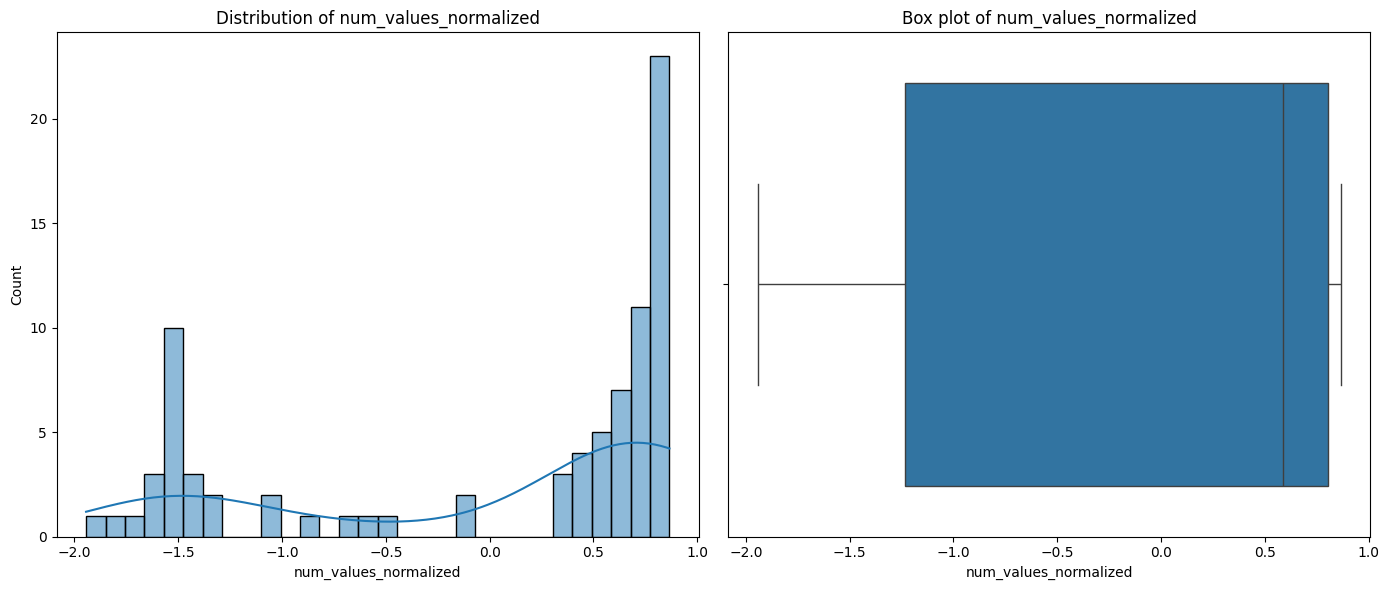

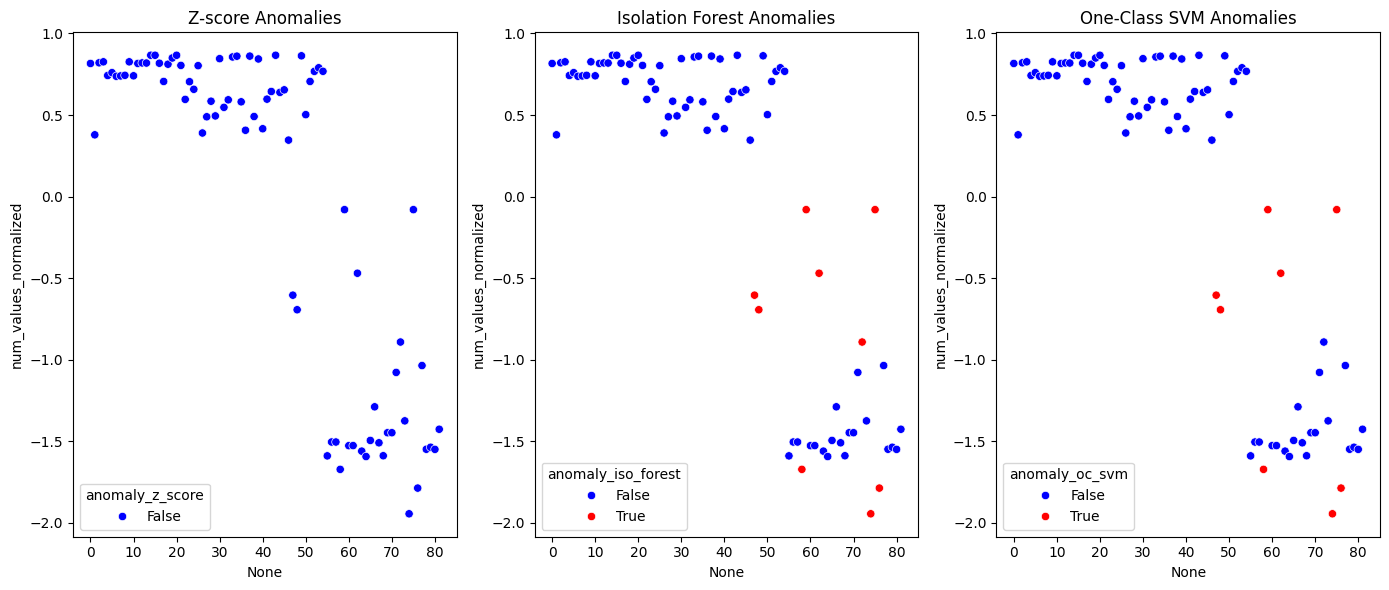

In [4]:
import seaborn as sns

import matplotlib.pyplot as plt

# Visualize the distribution of the 'num_values_normalized' feature
plt.figure(figsize=(14, 6))

# Distribution plot
plt.subplot(1, 2, 1)
sns.histplot(df['num_values_normalized'], kde=True, bins=30)
plt.title('Distribution of num_values_normalized')

# Box plot to show outliers
plt.subplot(1, 2, 2)
sns.boxplot(x=df['num_values_normalized'])
plt.title('Box plot of num_values_normalized')

plt.tight_layout()
plt.show()

# Visualize the detected anomalies
plt.figure(figsize=(14, 6))

# Z-score anomalies
plt.subplot(1, 3, 1)
sns.scatterplot(x=df.index, y=df['num_values_normalized'], hue=df['anomaly_z_score'], palette={True: 'red', False: 'blue'})
plt.title('Z-score Anomalies')

# Isolation Forest anomalies
plt.subplot(1, 3, 2)
sns.scatterplot(x=df.index, y=df['num_values_normalized'], hue=df['anomaly_iso_forest'], palette={True: 'red', False: 'blue'})
plt.title('Isolation Forest Anomalies')

# One-Class SVM anomalies
plt.subplot(1, 3, 3)
sns.scatterplot(x=df.index, y=df['num_values_normalized'], hue=df['anomaly_oc_svm'], palette={True: 'red', False: 'blue'})
plt.title('One-Class SVM Anomalies')

plt.tight_layout()
plt.show()